In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Conv1D, Flatten,\
                                    Reshape, MaxPooling1D,\
                                    Dropout, Conv1DTranspose, UpSampling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
from pyfaidx import Fasta
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
def encode_sequence(seq):
    
    d = {
    'A' : [1, 0, 0, 0],
    'C' : [0, 1, 0, 0],
    'G' : [0, 0, 1, 0],
    'T' : [0, 0, 0, 1], 
    'N' : [0.25, 0.25, 0.25, 0.25]}

    return np.array([d[nuc] for nuc in list(seq)]).astype('float32')

In [3]:
data = pd.read_csv("./Cell-Type-Specific-cCREs.txt", sep="\t", header=0)
data.head()

,chrom,start,stop,rDHS,cCRE,type,HepG2,K562,H1,GM12878,MCF-7,HeLa,SK-N-SH,nCells
0,chr1,10033,10250,EH38D4327497,EH38E2776516,pELS,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,chr1,181289,181639,EH38D4327525,EH38E2776524,CA-H3K4me3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,chr1,727121,727350,EH38D4327570,EH38E2776536,dELS,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,chr1,779715,780047,EH38D6144727,EH38E3951315,pELS,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,chr1,842777,843116,EH38D4327629,EH38E2776569,dELS,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
cells = data.columns[6:-1].tolist()
y_class = data[cells].values

In [6]:
print(cells)

['HepG2', 'K562', 'H1', 'GM12878', 'MCF-7', 'HeLa', 'SK-N-SH']


In [7]:
latent_dim = 256
# filters = 128
# kernel_size = 32
# layer_filters = [128, 128]

In [8]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

def kl_divergence_loss(inputs):
    mu, log_var = inputs
    outputs = -0.5 * (1 + log_var - tf.math.square(mu) - tf.math.exp(log_var))
    return(outputs)

In [9]:
from tensorflow.keras.optimizers import Adam
def vae1():
    l = 512
    img = Input(shape = (l, 4))
    encoder = img
    
    encoder = Conv1D(filters=256, 
                     name="conv",
               kernel_size=32,
               activation='relu',
               strides=1,
               padding='same')(encoder)
    
    encoder = MaxPooling1D(8)(encoder)
    
    encoder = Conv1D(filters=128,
               kernel_size=8,
               activation='relu',
               strides=1,
               padding='same')(encoder)
    
    encoder = MaxPooling1D(2)(encoder)
    shape = K.int_shape(encoder)
    
    encoder = Flatten()(encoder)
    encoder = Dense(1028)(encoder)
    encoder = Dense(512)(encoder)
    
    
    # Define output latent space
    z_mu = tf.keras.layers.Dense(latent_dim, name = 'z_mu')(encoder)
    z_log_var = tf.keras.layers.Dense(latent_dim, name = 'z_log_var')(encoder)
    z = tf.keras.layers.Lambda(sample_latent_features, name = 'latent_features')([z_mu, z_log_var])
    
    # Kullback-Leibler Divergence
    kl_div= tf.keras.layers.Lambda(kl_divergence_loss, name = 'kl_div')([z_mu, z_log_var])

    # Classifier
    classifier = tf.keras.layers.Dense(7, 
                                       activation = 'softmax', 
                                       name = 'classifier')(z)
    
    # latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    decoder = Dense(512)(z)
    decoder = Dense(1028)(decoder)
    decoder = Dense(shape[1] * shape[2])(decoder)
    decoder = Reshape((shape[1], shape[2]))(decoder)
    decoder = UpSampling1D(size=2)(decoder)
    decoder = Conv1DTranspose(128, kernel_size=8, strides=1, padding="same")(decoder)
    decoder = UpSampling1D(size=8)(decoder)
    decoder = Conv1DTranspose(l, kernel_size=32, strides=1, padding="same")(decoder)
    decoder = Conv1DTranspose(filters=4,
                              kernel_size=32,
                              activation='relu',
                              padding='same',
                              name='decoder')(decoder)
    
    vae_model = tf.keras.Model(img, [z_mu, z_log_var, z, kl_div, decoder, classifier])
    vae_model.summary()
    return(vae_model)

In [10]:
# from tensorflow.keras.optimizers import Adam
# def vae2():
#     l = 512
#     img = Input(shape = (l, 4))
#     encoder = img
    
#     encoder = Conv1D(filters=256, 
#                      name="conv",
#                kernel_size=32,
#                activation='relu',
#                strides=1,
#                padding='same')(encoder)
    
#     encoder = MaxPooling1D(8)(encoder)
    
#     encoder = Conv1D(filters=128,
#                kernel_size=3,
#                activation='relu',
#                strides=1,
#                padding='same')(encoder)
    
#     encoder = MaxPooling1D(2)(encoder)

#     encoder = Conv1D(filters=128,
#                kernel_size=3,
#                activation='relu',
#                strides=1,
#                padding='same')(encoder)
    
#     encoder = MaxPooling1D(2)(encoder)
    
#     shape = K.int_shape(encoder)
    
#     encoder = Flatten()(encoder)
#     encoder = Dense(1028)(encoder)
    
    
#     # Define output latent space
#     z_mu = tf.keras.layers.Dense(latent_dim, name = 'z_mu')(encoder)
#     z_log_var = tf.keras.layers.Dense(latent_dim, name = 'z_log_var')(encoder)
#     z = tf.keras.layers.Lambda(sample_latent_features, name = 'latent_features')([z_mu, z_log_var])
    
#     # Kullback-Leibler Divergence
#     kl_div= tf.keras.layers.Lambda(kl_divergence_loss, name = 'kl_div')([z_mu, z_log_var])

#     # Classifier
#     classifier = tf.keras.layers.Dense(7, 
#                                        activation = 'softmax', 
#                                        name = 'classifier')(z)
    
#     # latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
#     decoder = Dense(1028)(z)
#     decoder = Dense(shape[1] * shape[2])(decoder)
#     decoder = Reshape((shape[1], shape[2]))(decoder)
#     decoder = UpSampling1D(size=2)(decoder)
#     decoder = Conv1DTranspose(128, kernel_size=3, strides=1, padding="same")(decoder)
#     decoder = UpSampling1D(size=2)(decoder)
#     decoder = Conv1DTranspose(128, kernel_size=3, strides=1, padding="same")(decoder)
#     decoder = UpSampling1D(size=8)(decoder)
#     decoder = Conv1DTranspose(l, kernel_size=32, strides=1, padding="same")(decoder)
#     decoder = Conv1DTranspose(filters=4,
#                               kernel_size=32,
#                               activation='relu',
#                               padding='same',
#                               name='decoder')(decoder)
    
#     vae_model = tf.keras.Model(img, [z_mu, z_log_var, z, kl_div, decoder, classifier])
#     vae_model.summary()
#     return(vae_model)

In [40]:
vae_model = vae1()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 4)]     0           []                               
                                                                                                  
 conv (Conv1D)                  (None, 512, 256)     33024       ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 64, 256)     0           ['conv[0][0]']                   
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64, 128)      262272      ['max_pooling1d_2[0][0]']        
                                                                                            

In [41]:
# losses = {
#     "kl_div": "mean_absolute_error",
#     "classifier": "binary_crossentropy",
#     "decoder": "mean_squared_error",
# }

losses = {
    "kl_div": "mean_absolute_error",
    "classifier": "categorical_crossentropy",
    "decoder": "mean_squared_error",
}

loss_weights = {"kl_div": 1.0,
                "classifier" : 1.0,
               "decoder": 1.0}


vae_model.compile(optimizer=Adam(.0001), loss = losses, loss_weights=loss_weights)

In [42]:
genomeFasta = "/home/gregory.andrews-umw/data/genome/hg38.fa"
genome = Fasta(genomeFasta, sequence_always_upper=True, as_raw=True)
seqs = []
for index, row in data.iterrows():
    chrom, start, stop = row["chrom"], row["start"], row["stop"]
    center = (start + stop) // 2
    seqs.append(genome[chrom][center-256:center+256])

In [43]:
with Pool(8) as p:
    X = p.map(encode_sequence, seqs)

In [44]:
X = np.stack(X, axis=0)

In [45]:
# indices = data.index[data["nCells"] == 0]
# X = np.delete(X, indices, axis=0)
# data = data.drop(indices).reset_index()

indices = data.index[data["nCells"] == 1]
X = X[indices,:]
data = data.iloc[indices].reset_index()

In [46]:
X.shape

(298948, 512, 4)

In [47]:
y_kl = np.zeros(X.shape[0])
y_class = data[cells].values

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("cCREs-{epoch:02d}.hdf5", 
                             monitor='loss', 
                             verbose=1,
                             save_best_only=False,
                             mode='auto',
                             period=1)

In [49]:
vae_model.fit(X, {'decoder': X, 
                  'kl_div': y_kl,
                  "classifier" : y_class},
              epochs=20, callbacks = [checkpoint], 
              validation_split = 0.1)

Epoch 1/20
8405/8408 [============================>.] - ETA: 0s - loss: 2.2045 - kl_div_loss: 0.0533 - decoder_loss: 0.1867 - classifier_loss: 1.9645
Epoch 1: saving model to cCREs-01.hdf5
8408/8408 [==============================] - 144s 17ms/step - loss: 2.2044 - kl_div_loss: 0.0532 - decoder_loss: 0.1867 - classifier_loss: 1.9644 - val_loss: 2.0176 - val_kl_div_loss: 0.0363 - val_decoder_loss: 0.1862 - val_classifier_loss: 1.7952
Epoch 2/20
8406/8408 [============================>.] - ETA: 0s - loss: 1.9449 - kl_div_loss: 0.0357 - decoder_loss: 0.1861 - classifier_loss: 1.7230
Epoch 2: saving model to cCREs-02.hdf5
8408/8408 [==============================] - 140s 17ms/step - loss: 1.9449 - kl_div_loss: 0.0357 - decoder_loss: 0.1861 - classifier_loss: 1.7230 - val_loss: 1.8992 - val_kl_div_loss: 0.0452 - val_decoder_loss: 0.1860 - val_classifier_loss: 1.6680
Epoch 3/20
8406/8408 [============================>.] - ETA: 0s - loss: 1.8573 - kl_div_loss: 0.0469 - decoder_loss: 0.1862 - 

In [50]:
# vae_model.load_weights("cCREs-09.hdf5")

In [51]:
output = vae_model.predict(X)

In [52]:
output[0].shape

(298948, 256)

In [53]:
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA

In [54]:
# u = umap.UMAP().fit_transform(output[0])
pca = PCA(n_components=64).fit_transform(output[0])
u = umap.UMAP().fit_transform(pca)

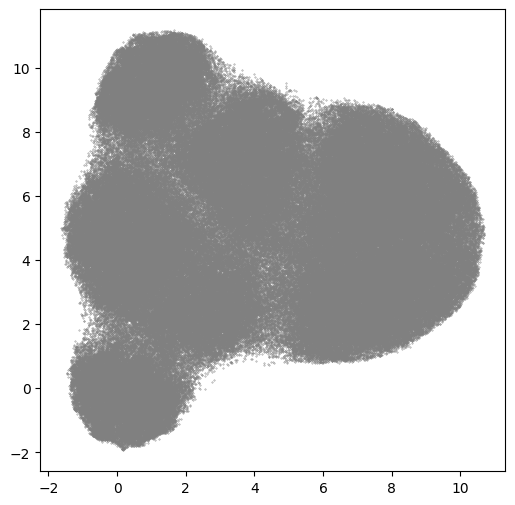

In [55]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(u[:,0], u[:,1], s=.1, color="gray")

Text(0, 0.5, 'UMAP 2')

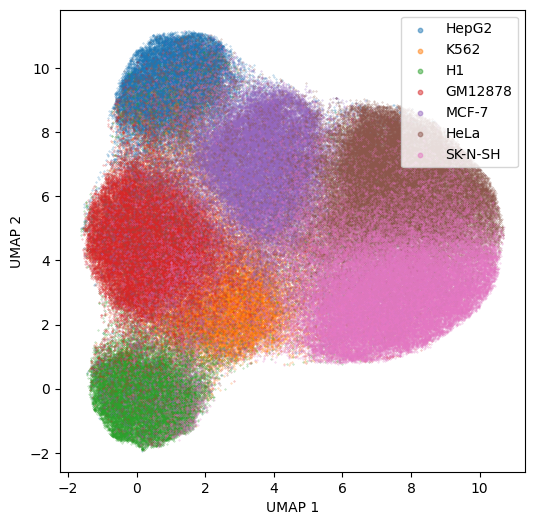

In [56]:
fig, ax = plt.subplots(figsize=(6,6))
for cell in cells:
    indices = data.index[(data[cell] == 1)]
    ax.scatter(u[indices,0], u[indices,1], s=.1, label=cell, alpha=0.5)

ax.legend(loc='upper right', markerscale=10)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

In [50]:
fig, axes = plt.subplots(4,2 , figsize=(6,2))
for cell in cells:
    indices = data.index[(data[cell] == 1)]
    ax.scatter(u[indices,0], u[indices,1], s=.1, label=cell)

ax.legend(loc='upper right', markerscale=10)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

73430

7